# ニューラルネット
## 第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．



####https://nlp100.github.io/ja/ch08.html

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iamtatsuki05/NLP_100/blob/NLP_100_8/NLP_100_8.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 単語ベクトルの和による特徴量
## 問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．

X=⎛⎝⎜⎜⎜⎜x1x2…xn⎞⎠⎟⎟⎟⎟∈ℝn×d,Y=⎛⎝⎜⎜⎜⎜y1y2…yn⎞⎠⎟⎟⎟⎟∈ℕn
ここで，nは学習データの事例数であり，xi∈ℝdとyi∈ℕはそれぞれ，i∈{1,…,n}番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．ℕ<4で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベルyiはyi∈ℕ<4で表現できる． 以降では，ラベルの種類数をLで表す（今回の分類タスクではL=4である）．

i番目の事例の特徴ベクトルxiは，次式で求める．

xi=1Ti∑t=1Tiemb(wi,t)
ここで，i番目の事例はTi個の（記事見出しの）単語列(wi,1,wi,2,…,wi,Ti)から構成され，emb(w)∈ℝdは単語wに対応する単語ベクトル（次元数はd）である．すなわち，i番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものがxiである．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，d=300である．

i番目の事例のラベルyiは，次のように定義する．

yi=⎧⎩⎨⎪⎪0123(記事xiが「ビジネス」カテゴリの場合)(記事xiが「科学技術」カテゴリの場合)(記事xiが「エンターテイメント」カテゴリの場合)(記事xiが「健康」カテゴリの場合)
なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

学習データの特徴量行列: Xtrain∈ℝNt×d
学習データのラベルベクトル: Ytrain∈ℕNt
検証データの特徴量行列: Xvalid∈ℝNv×d
検証データのラベルベクトル: Yvalid∈ℕNv
評価データの特徴量行列: Xtest∈ℝNe×d
評価データのラベルベクトル: Ytest∈ℕNe
なお，Nt,Nv,Neはそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [ ]:
# 学習データの特徴量行列: Xtrain
# 学習データのラベルベクトル: Ytrain
# 検証データの特徴量行列: Xvalid
# 検証データのラベルベクトル: Yvalid
# 評価データの特徴量行列: Xtest
# 評価データのラベルベクトル: Ytest
# Nt,Nv,Ne はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数．

# 問題50のデータをもう一度作成します。
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip
f = open('readme.txt', 'r')
data = f.read()
print(data)

--2022-03-25 08:28:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  21.2MB/s    in 1.3s    

2022-03-25 08:28:55 (21.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   
SUMMARY: Dataset of references (urls) to news web pages

DESCRIPTION: Dataset of references to news web pages collected fr

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/newsCorpora.csv' , header=None , sep='\t' , names=['ID' , 'TITLE' , 'URL' , 'PUBLISHER' , 'CATEGORY' , 'STORY' , 'HOSTNAME' , 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters' , 'Huffington Post' , 'Businessweek' , 'Contactmusic.com' , 'Daily Mail']) , ['TITLE' , 'CATEGORY']]

train , other = train_test_split(df , test_size=0.2, shuffle=True, random_state=42 , stratify=df['CATEGORY'])
valid , test = train_test_split(other , test_size=0.5, shuffle=True, random_state=42 , stratify=other['CATEGORY'])

In [1]:
# ダウンロード制限がかかっているのでprthを指定する
# #参考https://qiita.com/jun40vn/items/0f9bd5353197d3f14f3e
# ! pip install --upgrade gdown
# import gdown
# gdown.download('https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download', './GoogleNews-vectors-negative300.bin.gz', quiet=False)
# from gensim.models import KeyedVectors
# model_kv = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz' , binary=True)

In [ ]:
# 直接pathを指定する場合
from gensim.models import KeyedVectors
model_kv = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Tutorial/NLP_100/GoogleNews-vectors-negative300.bin.gz' , binary=True)

In [ ]:
# 特徴ベクトル化
import torch
import string

# 6章と同様の処理
def extract(df):
  # 記号変換
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = df.translate(table).split()
  # テンソル化
  vector = [model_kv[word] for word in words if word in model_kv]

  return torch.tensor(sum(vector) / len(vector))

In [ ]:
X_train = torch.stack([extract(txt) for txt in train['TITLE']])
X_valid = torch.stack([extract(txt) for txt in valid['TITLE']])
X_test = torch.stack([extract(txt) for txt in test['TITLE']])
X_train

tensor([[ 0.0085,  0.0628,  0.0180,  ..., -0.1601,  0.0352,  0.1221],
        [-0.0952,  0.0496,  0.0650,  ...,  0.0259, -0.0036,  0.1435],
        [ 0.0583,  0.0295, -0.0386,  ...,  0.0912,  0.1007, -0.1357],
        ...,
        [ 0.0287,  0.0165, -0.0757,  ..., -0.0712,  0.0378, -0.0391],
        [-0.0738, -0.0352, -0.0405,  ...,  0.0280,  0.0646,  0.0919],
        [ 0.0394,  0.0317,  0.0094,  ...,  0.0160,  0.0709,  0.0104]])

In [ ]:
# ラベル
label_map = {'b' : 0 , 't' : 1 , 'e' : 2 , 'm' : 3}
y_train = torch.LongTensor(train['CATEGORY'].map(lambda x: label_map[x]).values)
y_valid = torch.LongTensor(valid['CATEGORY'].map(lambda x: label_map[x]).values)
y_test = torch.LongTensor(test['CATEGORY'].map(lambda x: label_map[x]).values)
y_train

tensor([2, 0, 1,  ..., 2, 0, 0])

In [ ]:
# 参考https://tzmi.hatenablog.com/entry/2020/01/27/001036
# https://panda-clip.com/torch-stack/
# https://www.hellocybernetics.tech/entry/2017/10/19/070522
# https://codezine.jp/article/detail/11052
# https://qiita.com/jyori112/items/aad5703c1537c0139edb
# https://pytorch.org/docs/stable/generated/torch.save.html

# 単層ニューラルネットワークによる予測
## 問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

ŷ 1=softmax(x1W),Ŷ =softmax(X[1:4]W)
ただし，softmaxはソフトマックス関数，X[1:4]∈ℝ4×dは特徴ベクトルx1,x2,x3,x4を縦に並べた行列である．

X[1:4]=⎛⎝⎜⎜⎜⎜x1x2x3x4⎞⎠⎟⎟⎟⎟
行列W∈ℝd×Lは単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，ŷ 1∈ℝLは未学習の行列Wで事例x1を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，Ŷ ∈ℝn×Lは，学習データの事例x1,x2,x3,x4について，各カテゴリに属する確率を行列として表現している．



In [ ]:
from torch import nn , optim
import torch.nn.functional as F
import numpy as np
torch.manual_seed(42)

X_train = torch.tensor(X_train , requires_grad=True)
W = torch.randn(300 , 4)
softmax = torch.nn.Softmax(dim=-1)
print (f'1 : {softmax(torch.matmul(X_train[:1] , W))}')
print (f'4 : {softmax(torch.matmul(X_train[:4] , W))}')

1 : tensor([[0.0063, 0.1302, 0.0495, 0.8140]], grad_fn=<SoftmaxBackward0>)
4 : tensor([[0.0063, 0.1302, 0.0495, 0.8140],
        [0.2743, 0.6042, 0.0384, 0.0832],
        [0.1231, 0.1233, 0.5911, 0.1625],
        [0.3187, 0.5909, 0.0379, 0.0525]], grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
# 参考https://qiita.com/mathlive/items/2c67efa2d451ea1da1b1
# https://watlab-blog.com/2021/06/13/pytorch-nn-class/

# 損失と勾配の計算
## 学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例xiに対して損失は次式で計算される．

li=−log[事例xiがyiに分類される確率]
ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [ ]:
class model_ln(nn.Module):
  def __init__(self , input_size , output_size):
    super().__init__()
    self.fc = nn.Linear(input_size , output_size , bias=False)
    nn.init.normal_(self.fc.weight , 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self , x):
    x = self.fc(x)
    return x

In [ ]:
model = model_ln(300 , 4)
CE = nn.CrossEntropyLoss()

#_1
l_1 = CE(model(X_train[:1]) , y_train[:1])
model.zero_grad()
l_1.backward()# 誤差算出

print(f'クロスエントロピー損失 : {l_1}')
print(f'勾配 : {model.fc.weight.grad}')

クロスエントロピー損失 : 0.5793663859367371
勾配 : tensor([[ 0.0011,  0.0079,  0.0023,  ..., -0.0201,  0.0044,  0.0153],
        [ 0.0021,  0.0154,  0.0044,  ..., -0.0394,  0.0087,  0.0300],
        [-0.0038, -0.0276, -0.0079,  ...,  0.0704, -0.0155, -0.0537],
        [ 0.0006,  0.0043,  0.0012,  ..., -0.0109,  0.0024,  0.0083]])


In [ ]:
#_4
l_4 = CE(model(X_train[:4]) , y_train[:4])
model.zero_grad()
l_4.backward()

print(f'クロスエントロピー損失 : {l_4}')
print(f'勾配 : {model.fc.weight.grad}')

クロスエントロピー損失 : 1.5959115028381348
勾配 : tensor([[ 0.0238, -0.0343, -0.0255,  ..., -0.0219, -0.0253, -0.0209],
        [-0.0169,  0.0259,  0.0199,  ..., -0.0045,  0.0144,  0.0293],
        [-0.0066,  0.0039,  0.0039,  ...,  0.0271,  0.0065, -0.0096],
        [-0.0003,  0.0044,  0.0017,  ..., -0.0007,  0.0044,  0.0011]])


In [ ]:
#参考https://qiita.com/maechanneler/items/8f10a758d7d3431ae61f

# 確率的勾配降下法による学習
## 確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．



In [ ]:
from torch.utils.data import Dataset

class Creat_dataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self , idx):
    return [self.X[idx] , self.y[idx]]

In [ ]:
from torch.utils.data import DataLoader

ds_train = Creat_dataset(X_train , y_train)
ds_valid = Creat_dataset(X_valid , y_valid)
ds_test = Creat_dataset(X_test , y_test)

dataloader_train = DataLoader(ds_train , batch_size=1 , shuffle=True)#混ぜる
dataloader_valid = DataLoader(ds_valid , batch_size=len(ds_valid) , shuffle=False)
dataloader_test = DataLoader(ds_test , batch_size=len(ds_test) , shuffle=False)

In [ ]:
CE = nn.CrossEntropyLoss()
op = optim.SGD(model.parameters() , lr = 1e-3)

In [ ]:
#時間がかかるので少なめに設定する
for epoch in range(20):
    model.train()
    loss_train = 0.0
    for i, (inputs , labels) in enumerate(dataloader_train):
      op.zero_grad()#加算されてしまうのでリセット
      y_pred = model(inputs)#modelを用いて予測
      loss = CE(y_pred , labels)#誤差
      loss.backward()#誤差修正
      op.step()#更新
      loss_train += loss.item()#誤差

    loss_train = loss_train / i#平均誤差
    # 検証データ
    model.eval() 
    with torch.no_grad():
      inputs , labels = next(iter(dataloader_valid))
      outputs = model(inputs)
      loss_valid = CE(outputs , labels)

    print(f'epoch: {epoch + 1} , loss_train: {loss_train} , loss_valid: {loss_valid}')                 

epoch: 1 , loss_train: 1.404895549494003 , loss_valid: 1.1672850847244263
epoch: 2 , loss_train: 1.0891309485878504 , loss_valid: 0.9929269552230835
epoch: 3 , loss_train: 0.9519045932757569 , loss_valid: 0.8946924209594727
epoch: 4 , loss_train: 0.8657167982871842 , loss_valid: 0.8282597064971924
epoch: 5 , loss_train: 0.804440912005074 , loss_valid: 0.7795997858047485
epoch: 6 , loss_train: 0.7580619614297275 , loss_valid: 0.7417977452278137
epoch: 7 , loss_train: 0.7212088899141076 , loss_valid: 0.711331844329834
epoch: 8 , loss_train: 0.6909407464280732 , loss_valid: 0.6858582496643066
epoch: 9 , loss_train: 0.6653894606509304 , loss_valid: 0.6641205549240112
epoch: 10 , loss_train: 0.6433680368343034 , loss_valid: 0.6452613472938538
epoch: 11 , loss_train: 0.624077315962001 , loss_valid: 0.628528892993927
epoch: 12 , loss_train: 0.6069458323655945 , loss_valid: 0.6136081218719482
epoch: 13 , loss_train: 0.5915974705022612 , loss_valid: 0.6001834869384766
epoch: 14 , loss_train: 0.

In [ ]:
# 参考https://qiita.com/mathlive/items/2c67efa2d451ea1da1b1
# https://pytorch.org/docs/stable/optim.html

# 正解率の計測


## 問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [ ]:
# from sklearn.metrics import accuracy_score

# result_test = model_ln(X_test)
# train_score = accuracy_score(y_train / result)
# test_score = accuracy_score(y_test / result_test)
# print(f'train-score : {train_score}')
# print(f'test-score : {test_score}')

In [ ]:
def score(model , loader):
  model.eval()
  y_true = 0
  y_pred = 0
  with torch.no_grad():
    for inputs , labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs , dim=-1)
      y_true += len(inputs)
      y_pred += (pred == labels).sum().item()

  return y_pred / y_true

In [ ]:
score_train = score(model , dataloader_train)
score_test = score(model , dataloader_test)
print(f'train ： {score_train}')
print(f'valid ： {score_test}')

train ： 0.8191529235382309
valid ： 0.8013493253373314


In [ ]:
# 参考https://qiita.com/Haaamaaaaa/items/b9f47cba588b83ad34a7
# https://note.nkmk.me/python-pytorch-tensor-item/

# 損失と正解率のプロット


## 問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [ ]:
def loss_acc(model , criterion , loader):
  model.eval()
  loss = 0.0
  y_true = 0
  y_pred = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs , labels).item()#new
      pred = torch.argmax(outputs , dim=-1)
      y_true += len(inputs)
      y_pred += (pred == labels).sum().item()

  return loss / len(loader) , y_pred / y_true

In [ ]:
#時間がかかるので少なめに設定する
log_train = []
log_valid = []
for epoch in range(20):
  model.train()
  for inputs, labels in dataloader_train:
    op.zero_grad()#加算されてしまうのでリセット
    y_pred = model(inputs)#modelを用いて予測
    loss = CE(y_pred , labels)#誤差
    loss.backward()#誤差修正
    op.step()#更新

  # 正解率等の計算
  loss_train, acc_train = loss_acc(model , CE , dataloader_train)
  loss_valid, acc_valid = loss_acc(model , CE , dataloader_valid)
  log_train.append([loss_train , acc_train])
  log_valid.append([loss_valid , acc_valid])

  # ログを出力
  print(f'epoch : {epoch + 1} , loss_train : {loss_train} , accuracy_train : {acc_train} , loss_valid : {loss_valid} , accuracy_valid: {acc_valid}')  

epoch : 1 , loss_train : 0.503392419463739 , accuracy_train : 0.8222451274362819 , loss_valid : 0.5256772637367249 , accuracy_valid: 0.823088455772114
epoch : 2 , loss_train : 0.4962124562826554 , accuracy_train : 0.8249625187406296 , loss_valid : 0.519014298915863 , accuracy_valid: 0.8245877061469266
epoch : 3 , loss_train : 0.48946107770688174 , accuracy_train : 0.8276799100449775 , loss_valid : 0.5127905011177063 , accuracy_valid: 0.8268365817091454
epoch : 4 , loss_train : 0.48310462598933346 , accuracy_train : 0.830116191904048 , loss_valid : 0.5069438815116882 , accuracy_valid: 0.8298350824587706
epoch : 5 , loss_train : 0.47710595992540894 , accuracy_train : 0.83273988005997 , loss_valid : 0.5014556646347046 , accuracy_valid: 0.8305847076461769
epoch : 6 , loss_train : 0.47143653998211305 , accuracy_train : 0.8350824587706147 , loss_valid : 0.4962557554244995 , accuracy_valid: 0.8320839580209896
epoch : 7 , loss_train : 0.4660642658007753 , accuracy_train : 0.8367691154422788 , 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25613 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31572 missing from current font.
  font.set_

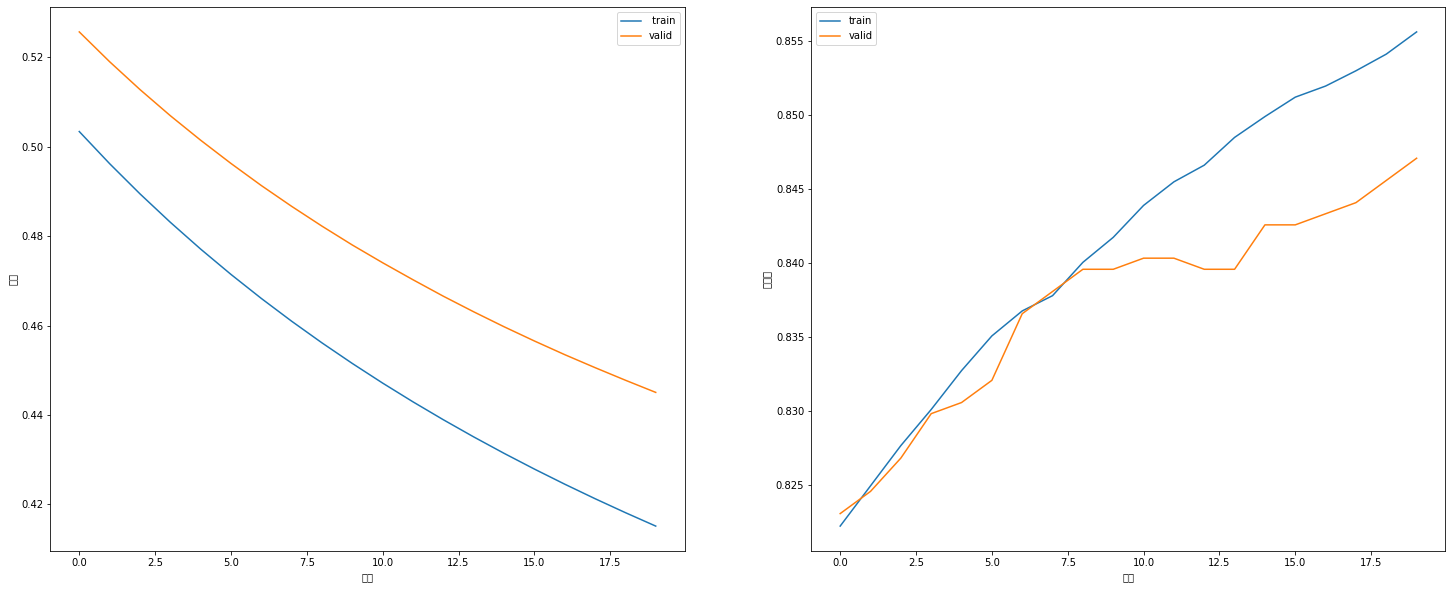

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig , ax = plt.subplots(1 , 2 , figsize=(25 , 10))
#loss_epoch
ax[0].plot(np.array(log_train).T[0] , label =' train')
ax[0].plot(np.array(log_valid).T[0] , label = 'valid')
ax[0].set_xlabel('回数')
ax[0].set_ylabel('損失')
ax[0].legend()
#acc_epoch
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('回数')
ax[1].set_ylabel('正答率')
ax[1].legend()
plt.show()

In [ ]:
# 参考https://yoshinashigoto-blog.herokuapp.com/detail/30/
# https://exture-ri.com/2021/01/04/pytorch-nn/
# https://yoshinashigoto-blog.herokuapp.com/detail/27/
# https://qiita.com/noknmgc/items/3b8531266e8986ca63fe
# https://qiita.com/awawaInu/items/e173acded17a142e6d02

# チェックポイント
## 問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．


In [ ]:
#時間がかかるので少なめに設定する
log_train = []
log_valid = []

for epoch in range(20):
  model.train()
  for inputs, labels in dataloader_train:
    op.zero_grad()#加算されてしまうのでリセット
    y_pred = model(inputs)#modelを用いて予測
    loss = CE(y_pred , labels)#誤差
    loss.backward()#誤差修正
    op.step()#更新

  # 正解率等の計算
  loss_train, acc_train = loss_acc(model , CE , dataloader_train)
  loss_valid, acc_valid = loss_acc(model , CE , dataloader_valid)
  log_train.append([loss_train , acc_train])
  log_valid.append([loss_valid , acc_valid])

  # チェックポイント new
  torch.save({'epoch' : epoch , 'model_state_dict' : model.state_dict() , 'optimizer_state_dict' : op.state_dict()} , f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch : {epoch + 1} , loss_train : {loss_train} , accuracy_train : {acc_train} , loss_valid : {loss_valid} , accuracy_valid: {acc_valid}')  

epoch : 1 , loss_train : 0.4122458914745348 , accuracy_train : 0.8564467766116941 , loss_valid : 0.44241562485694885 , accuracy_valid: 0.8470764617691154
epoch : 2 , loss_train : 0.40945080992551264 , accuracy_train : 0.8579460269865068 , loss_valid : 0.4398794174194336 , accuracy_valid: 0.8478260869565217
epoch : 3 , loss_train : 0.40675415259010134 , accuracy_train : 0.8588830584707646 , loss_valid : 0.4374454617500305 , accuracy_valid: 0.8478260869565217
epoch : 4 , loss_train : 0.40415248979245677 , accuracy_train : 0.8596326836581709 , loss_valid : 0.4350797235965729 , accuracy_valid: 0.8478260869565217
epoch : 5 , loss_train : 0.40163217652080674 , accuracy_train : 0.8605697151424287 , loss_valid : 0.43283331394195557 , accuracy_valid: 0.8470764617691154
epoch : 6 , loss_train : 0.39919700114394335 , accuracy_train : 0.8615067466266867 , loss_valid : 0.4306521713733673 , accuracy_valid: 0.8478260869565217
epoch : 7 , loss_train : 0.3968377358229445 , accuracy_train : 0.8623500749

# ミニバッチ化
## 問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [ ]:
import time

def train_model(ds_train , ds_valid , batch_size , model , CE , op , epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(ds_train , batch_size = batch_size , shuffle = True)
  dataloader_valid = DataLoader(ds_valid , batch_size = len(ds_valid) , shuffle = False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(epochs):
    start = time.time()#計測開始
    model.train()

    for inputs, labels in dataloader_train:
      op.zero_grad()#加算されてしまうのでリセット
      y_pred = model(inputs)#modelを用いて予測
      loss = CE(y_pred , labels)#誤差
      loss.backward()#誤差修正
      op.step()#更新

    # 正解率等の計算
    loss_train, acc_train = loss_acc(model , CE , dataloader_train)
    loss_valid, acc_valid = loss_acc(model , CE , dataloader_valid)
    log_train.append([loss_train , acc_train])
    log_valid.append([loss_valid , acc_valid])

    # # チェックポイント new
    # torch.save({'epoch' : epoch , 'model_state_dict' : model.state_dict() , 'optimizer_state_dict' : op.state_dict()} , f'checkpoint{epoch + 1}.pt')

    end = time.time()#計測完了

    # ログを出力
    print(f'epoch : {epoch + 1} , loss_train : {loss_train} , accuracy_train : {acc_train} , loss_valid : {loss_valid} , accuracy_valid : {acc_valid} , {end - start} sec') 

  return {'train' : log_train , 'valid' : log_valid}

In [ ]:
for batch_size in [2 ** i for i in range(5)]:
  print(f'バッチサイズ : {batch_size}')
  log = train_model(ds_train , ds_valid , batch_size , model , CE , op , 1)

バッチサイズ : 1
epoch : 1 , loss_train : 0.3701885119708702 , accuracy_train : 0.87321964017991 , loss_valid : 0.40486225485801697 , accuracy_valid : 0.8538230884557722 , 83.4313485622406 sec
バッチサイズ : 2
epoch : 1 , loss_train : 0.3694080877079589 , accuracy_train : 0.873688155922039 , loss_valid : 0.40416231751441956 , accuracy_valid : 0.8538230884557722 , 88.06749391555786 sec
バッチサイズ : 4
epoch : 1 , loss_train : 0.36902162891917695 , accuracy_train : 0.873688155922039 , loss_valid : 0.403816282749176 , accuracy_valid : 0.8538230884557722 , 96.84596705436707 sec
バッチサイズ : 8
epoch : 1 , loss_train : 0.3688293807564591 , accuracy_train : 0.8738755622188905 , loss_valid : 0.4036449193954468 , accuracy_valid : 0.8538230884557722 , 87.49002432823181 sec
バッチサイズ : 16
epoch : 1 , loss_train : 0.3687335105593326 , accuracy_train : 0.8738755622188905 , loss_valid : 0.40355968475341797 , accuracy_valid : 0.8538230884557722 , 88.67719316482544 sec


In [ ]:
# 参考https://gotutiyan.hatenablog.com/entry/2020/04/21/182937
# https://tzmi.hatenablog.com/entry/2020/04/11/234417
# https://qiita.com/kimisyo/items/9508aff5a25e70772d5c

# GPU上での学習
## 問題77のコードを改変し，GPU上で学習を実行せよ．

In [ ]:
def loss_acc_gpu(model , criterion , loader , device):
  model.eval()
  loss = 0.0
  y_true = 0
  y_pred = 0

  with torch.no_grad():
    for inputs, labels in loader:

      inputs = inputs.to(device)#gpu
      labels = labels.to(device)#gpu

      outputs = model(inputs)
      loss += criterion(outputs , labels).item()#new
      pred = torch.argmax(outputs , dim=-1)
      y_true += len(inputs)
      y_pred += (pred == labels).sum().item()

  return loss / len(loader) , y_pred / y_true

In [ ]:
def train_model(ds_train , ds_valid , batch_size , model , CE , op , epochs , device=None):
  model.to(device)#gpu
  # dataloaderの作成
  dataloader_train = DataLoader(ds_train , batch_size = batch_size , shuffle = True)
  dataloader_valid = DataLoader(ds_valid , batch_size = len(ds_valid) , shuffle = False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(epochs):
    start = time.time()#計測開始
    model.train()

    for inputs, labels in dataloader_train:
      op.zero_grad()#加算されてしまうのでリセット

      inputs = inputs.to(device)#gpu
      labels = labels.to(device)#gpu

      y_pred = model(inputs)#modelを用いて予測
      loss = CE(y_pred , labels)#誤差
      loss.backward()#誤差修正
      op.step()#更新

    # 正解率等の計算
    loss_train, acc_train = loss_acc_gpu(model , CE , dataloader_train , device)#gpu
    loss_valid, acc_valid = loss_acc_gpu(model , CE , dataloader_valid , device)#gpu
    log_train.append([loss_train , acc_train])
    log_valid.append([loss_valid , acc_valid])

    # # チェックポイント new
    # torch.save({'epoch' : epoch , 'model_state_dict' : model.state_dict() , 'optimizer_state_dict' : op.state_dict()} , f'checkpoint{epoch + 1}.pt')

    end = time.time()#計測完了

    # ログを出力
    print(f'epoch : {epoch + 1} , loss_train : {loss_train} , accuracy_train : {acc_train} , loss_valid : {loss_valid} , accuracy_valid : {acc_valid} , {end - start} sec') 

  return {'train' : log_train , 'valid' : log_valid}

In [ ]:
# device = torch.device('cuda') #gpu
device = torch.device('cpu')#制限があるのでcpu
print(device)

for batch_size in [2 ** i for i in range(4)]:
  print(f'バッチサイズ : {batch_size}')
  log = train_model(ds_train , ds_valid , batch_size , model , CE , op , 1 , device = device)

cpu
バッチサイズ : 1
epoch : 1 , loss_train : 0.3672223709019946 , accuracy_train : 0.8742503748125937 , loss_valid : 0.40223586559295654 , accuracy_valid : 0.8538230884557722 , 76.57336664199829 sec
バッチサイズ : 2
epoch : 1 , loss_train : 0.36647674081795106 , accuracy_train : 0.8746251874062968 , loss_valid : 0.40156421065330505 , accuracy_valid : 0.8538230884557722 , 83.40298008918762 sec
バッチサイズ : 4
epoch : 1 , loss_train : 0.3661079147982975 , accuracy_train : 0.8748125937031485 , loss_valid : 0.40123671293258667 , accuracy_valid : 0.8538230884557722 , 100.47651886940002 sec
バッチサイズ : 8
epoch : 1 , loss_train : 0.3659244774927342 , accuracy_train : 0.8749062968515742 , loss_valid : 0.4010739028453827 , accuracy_valid : 0.8538230884557722 , 103.40727543830872 sec


In [ ]:
# 参考https://note.nkmk.me/python-pytorch-cuda-is-available-device-count/
# https://atmarkit.itmedia.co.jp/ait/articles/2008/28/news030.html

# 多層ニューラルネットワーク
## 問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [ ]:
class model_ln_layers(nn.Module):
  def __init__(self , input_size , mid_size , output_size , mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size , mid_size)
    self.fc_mid = nn.Linear(mid_size , mid_size)
    self.fc_out = nn.Linear(mid_size , output_size)
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

In [ ]:
#時間がかかるので少なめに設定する
model = model_ln_layers(300 , 200 , 4 , 5)

log = train_model(ds_train , ds_valid , 64 , model , CE , op , 20 , device)

epoch : 1 , loss_train : 1.314777294318833 , accuracy_train : 0.4233508245877061 , loss_valid : 1.3133128881454468 , accuracy_valid : 0.4370314842578711 , 89.47175192832947 sec
epoch : 2 , loss_train : 1.306501724762831 , accuracy_train : 0.4258808095952024 , loss_valid : 1.3054394721984863 , accuracy_valid : 0.43853073463268366 , 81.22236204147339 sec
epoch : 3 , loss_train : 1.3068012898553631 , accuracy_train : 0.42859820089955025 , loss_valid : 1.3053441047668457 , accuracy_valid : 0.444527736131934 , 90.06787443161011 sec
epoch : 4 , loss_train : 1.3041399060609098 , accuracy_train : 0.43412668665667165 , loss_valid : 1.3027397394180298 , accuracy_valid : 0.43928035982008995 , 91.12173247337341 sec
epoch : 5 , loss_train : 1.3150213342940735 , accuracy_train : 0.42278860569715143 , loss_valid : 1.3131769895553589 , accuracy_valid : 0.4250374812593703 , 84.9083023071289 sec
epoch : 6 , loss_train : 1.3169994361386328 , accuracy_train : 0.4188530734632684 , loss_valid : 1.3158607482

In [ ]:
# 参考https://qiita.com/sudamasahiko/items/b54fed1ffe8bb6d48818
# https://atmarkit.itmedia.co.jp/ait/articles/2002/06/news025.html
# https://recruit.gmo.jp/engineer/jisedai/blog/pytorch_simplenn_to_gan/
# https://wonderfuru.com/scheduler/
# https://katsura-jp.hatenablog.com/entry/2019/01/30/183501